# <ins> Project 4 Twitter Sentiment<ins>



## Business Understanding
Tasked with creating a machine learning model that can properly identify tweets as positive to allow our marketing team to see the effects of their 

## Data Understanding

Data is taken from [data.world]("https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv"). According to their website "Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093"

In [198]:
import sklearn
import imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, regexp_tokenize
from nltk.util import bigrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
import re

In [133]:
## Data Preparation
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding='latin1')

In [134]:
df 

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


There are 5802 values that are missing in is there an emotion directed at a brand or product column, one missing in the first column which we will drop and 0 missing in the last column. In addition, there are many values that we will want to fill in as we go through data cleaning because they are mislabeled as neutral but contain an emotion.

In [139]:
#dropping tweets that have no values cause it is useless to us
df = df.iloc[:-1]  #Drops the last row
df = df.dropna(subset=['tweet_text'])
df['tweet_text'].isna().sum()

0

### Data Cleaning
Our first step will be tokenizing the first column, in order to do so we will need to convert our columns from object data types to strings, convert all words to lower case for uniformity and remove unnecessary symbols. 

In [140]:
# Checking to make sure Dtype is string type for tokenizing
print(type(df['tweet_text'].iloc[13]))

<class 'str'>


In [141]:
tweet_tokenizer = TweetTokenizer(preserve_case=True)

In [142]:
df = df.copy()
df['tweet_tokens'] = df['tweet_text'].astype(str).apply(lambda x: tweet_tokenizer.tokenize(x))

# Display the DataFrame
print(df[['tweet_text', 'tweet_tokens']])

                                             tweet_text  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1     @jessedee Know about @fludapp ? Awesome iPad/i...   
2     @swonderlin Can not wait for #iPad 2 also. The...   
3     @sxsw I hope this year's festival isn't as cra...   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...   
...                                                 ...   
9087  @mention Yup, but I don't have a third app yet...   
9088                      Ipad everywhere. #SXSW {link}   
9089  Wave, buzz... RT @mention We interrupt your re...   
9090  Google's Zeiger, a physician never reported po...   
9091  Some Verizon iPhone customers complained their...   

                                           tweet_tokens  
0     [., @wesley83, I, have, a, 3G, iPhone, ., Afte...  
1     [@jessedee, Know, about, @fludapp, ?, Awesome,...  
2     [@swonderlin, Can, not, wait, for, #iPad, 2, a...  
3     [@sxsw, I, hope, this, year's, festival, isn't...  
4

In [143]:
print(df['tweet_tokens'].apply(type).unique())  # Should only show <class 'list'>

[<class 'list'>]


In [144]:
# Gettings list of stop words
stop_words = set(stopwords.words('english'))

In [145]:
#lower casing all tokens in tweet_tokens
df['filtered'] = df['tweet_tokens'].apply(lambda tokens: [token.lower() for token in tokens])

In [146]:
df['filtered'].head()

0    [., @wesley83, i, have, a, 3g, iphone, ., afte...
1    [@jessedee, know, about, @fludapp, ?, awesome,...
2    [@swonderlin, can, not, wait, for, #ipad, 2, a...
3    [@sxsw, i, hope, this, year's, festival, isn't...
4    [@sxtxstate, great, stuff, on, fri, #sxsw, :, ...
Name: filtered, dtype: object

In [147]:
# Remove stopwords from the 'tweet_tokens' column
df['filtered_tokens'] = df['filtered'].apply(
    lambda tokens: [token for token in tokens if token not in stop_words]
)

# Check the result
print(df[['tweet_tokens', 'filtered_tokens']].head())

                                        tweet_tokens  \
0  [., @wesley83, I, have, a, 3G, iPhone, ., Afte...   
1  [@jessedee, Know, about, @fludapp, ?, Awesome,...   
2  [@swonderlin, Can, not, wait, for, #iPad, 2, a...   
3  [@sxsw, I, hope, this, year's, festival, isn't...   
4  [@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...   

                                     filtered_tokens  
0  [., @wesley83, 3g, iphone, ., 3, hrs, tweeting...  
1  [@jessedee, know, @fludapp, ?, awesome, ipad, ...  
2  [@swonderlin, wait, #ipad, 2, also, ., sale, #...  
3  [@sxsw, hope, year's, festival, crashy, year's...  
4  [@sxtxstate, great, stuff, fri, #sxsw, :, mari...  


In [148]:
# Remove punctuation while keeping words, numbers, @mentions, and #hashtags
#df['clean_tokens'] = df['filtered_tokens'].apply(
#    lambda tokens: [re.sub(r'[^\w#@]', '', token) for token in tokens if re.sub(r'[^\w#@]', '', token)]
#)

df['clean_tokens'] = df['filtered_tokens'].apply(
    lambda tokens: [re.sub(r'[\d\W_]+', '', token) for token in tokens if re.sub(r'[\d\W_]+', '', token)]
)

print(df[['filtered_tokens', 'clean_tokens']].head(10))

                                      filtered_tokens  \
0   [., @wesley83, 3g, iphone, ., 3, hrs, tweeting...   
1   [@jessedee, know, @fludapp, ?, awesome, ipad, ...   
2   [@swonderlin, wait, #ipad, 2, also, ., sale, #...   
3   [@sxsw, hope, year's, festival, crashy, year's...   
4   [@sxtxstate, great, stuff, fri, #sxsw, :, mari...   
5   [@teachntech00, new, ipad, apps, #speechtherap...   
7   [#sxsw, starting, ,, #ctia, around, corner, #g...   
8   [beautifully, smart, simple, idea, rt, @madeby...   
9   [counting, days, #sxsw, plus, strong, canadian...   
10  [excited, meet, @samsungmobileus, #sxsw, show,...   

                                         clean_tokens  
0   [wesley, g, iphone, hrs, tweeting, riseaustin,...  
1   [jessedee, know, fludapp, awesome, ipad, iphon...  
2          [swonderlin, wait, ipad, also, sale, sxsw]  
3   [sxsw, hope, years, festival, crashy, years, i...  
4   [sxtxstate, great, stuff, fri, sxsw, marissa, ...  
5   [teachntech, new, ipad, apps, sp

In [149]:
def flatten_tokens(df, column_name):
    """
    Flattens a DataFrame column containing lists of tokens into a single list of all tokens.

    Args:
    df (pd.DataFrame): The DataFrame containing the column to flatten.
    column_name (str): The name of the column containing lists of tokens.

    Returns:
    list: A flattened list of all tokens from the column.
    """
    return [token for tokens in df[column_name] for token in tokens]

In [150]:
all_tokens = flatten_tokens(df, 'clean_tokens')

In [151]:
freqdist = FreqDist(all_tokens)

[('sxsw', 9623), ('mention', 7123), ('link', 4312), ('ipad', 2981), ('rt', 2966), ('google', 2458), ('apple', 2227), ('iphone', 1578), ('store', 1480), ('new', 1090), ('austin', 957), ('app', 820), ('circles', 674), ('launch', 653), ('social', 649), ('popup', 630), ('android', 592), ('today', 574), ('network', 466), ('via', 436)]


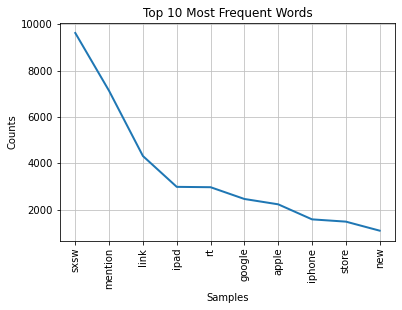

In [152]:
# most common 20 words
print(freqdist.most_common(20))
# Plot the top 10 words
freqdist.plot(10, title="Top 10 Most Frequent Words")
plt.show()

In [153]:
all_tokens_tagged = pos_tag(all_tokens)

In [154]:
def get_wordnet_pos(treebank_tag):
    return {"J": wordnet.ADJ, "V": wordnet.VERB, "N": wordnet.NOUN, "R": wordnet.ADV}.get(treebank_tag[0], wordnet.NOUN)
                      

In [155]:
#lemmatizing our corpus to see if the distribution changes
lemmatizer = WordNetLemmatizer()

# Apply POS tagging & lemmatization
df['pos_lemmatized_tokens'] = df['clean_tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tag(tokens)]
)
print(df[['clean_tokens', 'pos_lemmatized_tokens']].head())

                                        clean_tokens  \
0  [wesley, g, iphone, hrs, tweeting, riseaustin,...   
1  [jessedee, know, fludapp, awesome, ipad, iphon...   
2         [swonderlin, wait, ipad, also, sale, sxsw]   
3  [sxsw, hope, years, festival, crashy, years, i...   
4  [sxtxstate, great, stuff, fri, sxsw, marissa, ...   

                               pos_lemmatized_tokens  
0  [wesley, g, iphone, hr, tweet, riseaustin, dea...  
1  [jessedee, know, fludapp, awesome, ipad, iphon...  
2         [swonderlin, wait, ipad, also, sale, sxsw]  
3  [sxsw, hope, year, festival, crashy, year, iph...  
4  [sxtxstate, great, stuff, fri, sxsw, marissa, ...  


In [156]:
all_tokens = flatten_tokens(df, 'pos_lemmatized_tokens')
freqdist = FreqDist(all_tokens)

[('sxsw', 9623), ('mention', 7131), ('link', 4328), ('ipad', 2981), ('rt', 2966), ('google', 2646), ('apple', 2315), ('iphone', 1578), ('store', 1519), ('new', 1094), ('austin', 960), ('launch', 828), ('app', 820), ('get', 703), ('circle', 690), ('social', 649), ('popup', 630), ('android', 594), ('today', 579), ('open', 524)]


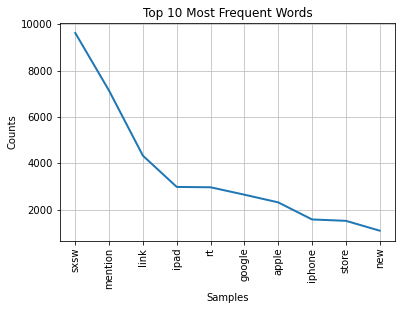

In [157]:
# most common 20 words
print(freqdist.most_common(20))
# Plot the top 10 words
freqdist.plot(10, title="Top 10 Most Frequent Words")
plt.show()

In [158]:
#creating list of terms related to apple and google
apple_keywords = {"apple", "ipad", "iphone", "ios", "mac", "macbook", "safari"}
google_keywords = {"google", "android", "pixel", "chrome", "chromebook", "gmail", "youtube", "search"}

In [159]:
# Function to assign missing brand based on keywords
def assign_brand(tokens, existing_brand):
    if pd.notna(existing_brand):  # If already labeled, keep it
        return existing_brand
    tokens_set = set(tokens)  # Convert tokens list to a set for faster lookup
    if tokens_set & apple_keywords:
        return "Apple"
    elif tokens_set & google_keywords:
        return "Google"
    else:
        return "Other"  # Assign "Other" if no brand is detected

# Apply the function to fill missing brand values
df['brand_category'] = df.apply(lambda row: assign_brand(row['pos_lemmatized_tokens'], row['brand_category']), axis=1)

# Check updated counts
print(df['brand_category'].value_counts())

Apple     5499
Google    2790
Other      802
Name: brand_category, dtype: int64


In [160]:
#heavily scewed toward apple
df['brand_category'].value_counts()

Apple     5499
Google    2790
Other      802
Name: brand_category, dtype: int64

In [161]:
df['brand_category'].isna().sum()

0

In [162]:
  >>> nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jared\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [163]:
# Using a prebuilt sentiment analyzer called VADER cause star wars to fill in mislabeled values in our third column.
sia  = SentimentIntensityAnalyzer()

In [164]:
# Apply VADER sentiment classification to a new column
df['vader_sentiment'] = df['tweet_text'].apply(lambda text: 
    "Positive emotion" if sia.polarity_scores(str(text))['compound'] > 0.05 
    else "Negative emotion" if sia.polarity_scores(str(text))['compound'] < -0.05 
    else "Neutral emotion"
)

In [165]:
print(df['vader_sentiment'].value_counts())

Positive emotion    3991
Neutral emotion     3946
Negative emotion    1154
Name: vader_sentiment, dtype: int64


In [166]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,brand_category,brand_combined,tweet_tokens,filtered,filtered_tokens,clean_tokens,pos_lemmatized_tokens,vader_sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,Apple,"[., @wesley83, I, have, a, 3G, iPhone, ., Afte...","[., @wesley83, i, have, a, 3g, iphone, ., afte...","[., @wesley83, 3g, iphone, ., 3, hrs, tweeting...","[wesley, g, iphone, hrs, tweeting, riseaustin,...","[wesley, g, iphone, hr, tweet, riseaustin, dea...",Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,Apple,"[@jessedee, Know, about, @fludapp, ?, Awesome,...","[@jessedee, know, about, @fludapp, ?, awesome,...","[@jessedee, know, @fludapp, ?, awesome, ipad, ...","[jessedee, know, fludapp, awesome, ipad, iphon...","[jessedee, know, fludapp, awesome, ipad, iphon...",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,Apple,"[@swonderlin, Can, not, wait, for, #iPad, 2, a...","[@swonderlin, can, not, wait, for, #ipad, 2, a...","[@swonderlin, wait, #ipad, 2, also, ., sale, #...","[swonderlin, wait, ipad, also, sale, sxsw]","[swonderlin, wait, ipad, also, sale, sxsw]",Neutral emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,Apple,"[@sxsw, I, hope, this, year's, festival, isn't...","[@sxsw, i, hope, this, year's, festival, isn't...","[@sxsw, hope, year's, festival, crashy, year's...","[sxsw, hope, years, festival, crashy, years, i...","[sxsw, hope, year, festival, crashy, year, iph...",Positive emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,Google,"[@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...","[@sxtxstate, great, stuff, on, fri, #sxsw, :, ...","[@sxtxstate, great, stuff, fri, #sxsw, :, mari...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...","[sxtxstate, great, stuff, fri, sxsw, marissa, ...",Positive emotion
...,...,...,...,...,...,...,...,...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product,Google,NaN,"[@mention, Yup, ,, but, I, don't, have, a, thi...","[@mention, yup, ,, but, i, don't, have, a, thi...","[@mention, yup, ,, third, app, yet, ., i'm, an...","[mention, yup, third, app, yet, im, android, s...","[mention, yup, third, app, yet, im, android, s...",Neutral emotion
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple,Apple,"[Ipad, everywhere, ., #SXSW, {, link, }]","[ipad, everywhere, ., #sxsw, {, link, }]","[ipad, everywhere, ., #sxsw, {, link, }]","[ipad, everywhere, sxsw, link]","[ipad, everywhere, sxsw, link]",Neutral emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,Google,NaN,"[Wave, ,, buzz, ..., RT, @mention, We, interru...","[wave, ,, buzz, ..., rt, @mention, we, interru...","[wave, ,, buzz, ..., rt, @mention, interrupt, ...","[wave, buzz, rt, mention, interrupt, regularly...","[wave, buzz, rt, mention, interrupt, regularly...",Negative emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,Google,NaN,"[Google's, Zeiger, ,, a, physician, never, rep...","[google's, zeiger, ,, a, physician, never, rep...","[google's, zeiger, ,, physician, never, report...","[googles, zeiger, physician, never, reported, ...","[google, zeiger, physician, never, report, pot...",Neutral emotion


In [167]:
print(df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())
print(df['vader_sentiment'].value_counts())

No emotion toward brand or product    5387
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64
Positive emotion    3991
Neutral emotion     3946
Negative emotion    1154
Name: vader_sentiment, dtype: int64


In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9091
Data columns (total 11 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9091 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9091 non-null   object
 3   brand_category                                      9091 non-null   object
 4   brand_combined                                      3291 non-null   object
 5   tweet_tokens                                        9091 non-null   object
 6   filtered                                            9091 non-null   object
 7   filtered_tokens                                     9091 non-null   object
 8   clean_tokens                                        9091 non-null   object
 9   pos_lemm

While by no means perfect, this is much more balanced and representative of the overall dataset but we still have a class imbalance and a lot of neutral tweets. Our target is to see which brand has more positive emotions associated with it and it would be more costly to categorize a neutral emotion as a positive one rather than a negative. As such we will be combining negative and neutral emotions and assigning positive emotions to 1 as our target variable

In [169]:
df['vader_target'] = df['vader_sentiment'].apply(lambda x: 1 if x == "Positive emotion" else 0)

print(df['vader_target'].value_counts())

0    5100
1    3991
Name: vader_target, dtype: int64


In [170]:
#Converting cleaned pos_lemmatized_tokens into text to vectorize
df['clean_text'] = df['pos_lemmatized_tokens'].apply(lambda tokens: " ".join(tokens))
df['clean_text']

0       wesley g iphone hr tweet riseaustin dead need ...
1       jessedee know fludapp awesome ipad iphone app ...
2                     swonderlin wait ipad also sale sxsw
3       sxsw hope year festival crashy year iphone app...
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
9087    mention yup third app yet im android suggestio...
9088                            ipad everywhere sxsw link
9089    wave buzz rt mention interrupt regularly sched...
9090    google zeiger physician never report potential...
9091    verizon iphone customer complain time fell bac...
Name: clean_text, Length: 9091, dtype: object

In [171]:
# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Fit & transform the text
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())


In [172]:
tfidf_df.head(10)

,aapl,aaron,aarpbulletin,ab,abacus,abandon,abba,abc,aber,ability,...,ûïview,ûïwin,ûò,ûòand,ûó,ûócan,ûójust,ûólewis,ûólots,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [173]:
print(tfidf.get_feature_names_out()[:20])  # Check first 20 features


['aapl' 'aaron' 'aarpbulletin' 'ab' 'abacus' 'abandon' 'abba' 'abc' 'aber'
 'ability' 'able' 'abnormal' 'abound' 'abroad' 'absolute' 'absolutely'
 'absolutley' 'abt' 'abuzz' 'academy']


In [174]:
print((tfidf_df != 0).sum().sum())  # Total nonzero values

99061


In [175]:
print(tfidf_df.sum(axis=1).value_counts())  # Distribution of nonzero rows

3.532131    21
3.304019    16
3.133270    12
3.336704    10
2.103481     8
            ..
2.753584     1
3.287456     1
2.389312     1
2.868765     1
3.111957     1
Length: 8761, dtype: int64


Our values should be ready for analysis, some things to keep in mind are if I want to remove numbers, and @mention values

In [176]:
# Define target variable (convert categorical labels to numerical)
y = df['vader_target']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Training Set: {X_train.shape}, Test Set: {X_test.shape}")

Training Set: (7272, 5000), Test Set: (1819, 5000)
Training Set: (7272, 5000), Test Set: (1819, 5000)


In [177]:
y

0       0
1       1
2       0
3       1
4       1
       ..
9087    0
9088    0
9089    0
9090    0
9091    0
Name: vader_target, Length: 9091, dtype: int64

## Modeling
starting with building a basic logistic regression for comparision sake

In [178]:
# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

Model Accuracy: 0.8499175371083013

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87       997
           1       0.89      0.76      0.82       822

    accuracy                           0.85      1819
   macro avg       0.86      0.84      0.85      1819
weighted avg       0.85      0.85      0.85      1819



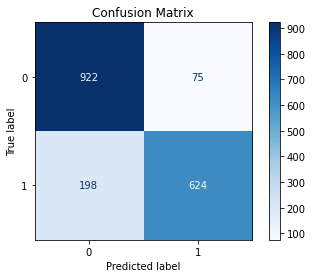

In [179]:
# Print accuracy score
print("Model Accuracy:", accuracy_score(y_test, y_pred))

# Print classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [180]:
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_[0]

# Sort top features by importance
top_features = sorted(zip(coefficients, feature_names), reverse=True, key=lambda x: abs(x[0]))

print("Top 10 Most Important Words for Classification:")
for coef, word in top_features[:10]:
    print(f"{word}: {coef:.4f}")

Top 10 Most Important Words for Classification:
free: 6.3753
great: 6.0168
like: 5.9917
party: 5.6786
love: 5.6401
good: 5.3781
win: 4.6538
cool: 4.3911
best: 4.3488
thanks: 4.3345


This is a good start for a baseline log model that predicts whether a tweet is positive or negative. We will continue to iterate through this process if we can do better. It is worth noting that our model has a higher precision than recall score, which with data imbalance is preferred but we'll try to improve both as well as our classification. Since our data is already cleaned this shouldn't be too difficult. 

In [181]:
# Group by brand and sentiment
brand_sentiment_counts = df.groupby(['brand_category', 'vader_sentiment']).size().unstack()

# Normalize counts to get percentages
brand_sentiment_percent = brand_sentiment_counts.div(brand_sentiment_counts.sum(axis=1), axis=0) * 100
brand_sentiment_percent

vader_sentiment,Negative emotion,Neutral emotion,Positive emotion
brand_category,,,
Apple,13.747954,42.625932,43.626114
Google,11.684588,47.777778,40.537634
Other,8.977556,33.541147,57.481297


In [182]:
df['brand_combined']

0        Apple
1        Apple
2        Apple
3        Apple
4       Google
         ...  
9087       NaN
9088     Apple
9089       NaN
9090       NaN
9091       NaN
Name: brand_combined, Length: 9091, dtype: object

In [183]:
df_brand = df[df['brand_combined'].isin(['Apple', 'Google'])].copy()

# Define target labels (1 for Apple, 0 for Google)
y_brand = df_brand['brand_combined'].map({'Apple': 1, 'Google': 0})

# Split data into training and test sets
X_train_brand, X_test_brand, y_train_brand, y_test_brand = train_test_split(
    df_brand['clean_text'], y_brand, test_size=0.2, random_state=42
)

# Create pipeline with CountVectorizer and MultinomialNB
brand_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),  
    ('classifier', MultinomialNB())  
])

# Train the model
brand_pipeline.fit(X_train_brand, y_train_brand)

# Evaluate the classifier
y_pred_brand = brand_pipeline.predict(X_test_brand)

print("Brand Classification Accuracy:", accuracy_score(y_test_brand, y_pred_brand))
print("\nClassification Report:\n", classification_report(y_test_brand, y_pred_brand))

# Predict the brand for all tweets
df['predicted_brand'] = brand_pipeline.predict(df['clean_text'])
df['predicted_brand'] = df['predicted_brand'].map({1: 'Apple', 0: 'Google'})

Brand Classification Accuracy: 0.9802731411229135

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       164
           1       0.98      1.00      0.99       495

    accuracy                           0.98       659
   macro avg       0.98      0.96      0.97       659
weighted avg       0.98      0.98      0.98       659



This allows us to now run our pipeline over the entire dataset in order to determine if a tweet is either Apple or Google rather than using 

In [184]:
#Updated brands, heavily scewed toward Apple
df['predicted_brand'].value_counts()

Apple     6243
Google    2848
Name: predicted_brand, dtype: int64

In [185]:
# Filter dataset to only include positive and negative sentiment
df_sentiment = df[df['vader_sentiment'] != 'Neutral emotion'].copy()

# Define target labels (1 for Positive, 0 for Negative)
y_sentiment = df_sentiment['vader_sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

# Split data into training and test sets
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df_sentiment['clean_text'], y_sentiment, test_size=0.2, random_state=42
)

# Create pipeline with TF-IDF and RandomForestClassifier
sentiment_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=5000)),  
    ('classifier', RandomForestClassifier(n_estimators=200,  class_weight='balanced', random_state=42))  
])

# Train the model
sentiment_pipeline.fit(X_train_sent, y_train_sent)

# Evaluate the classifier
y_pred_sent = sentiment_pipeline.predict(X_test_sent)

print("Sentiment Classification Accuracy:", accuracy_score(y_test_sent, y_pred_sent))
print("\nClassification Report:\n", classification_report(y_test_sent, y_pred_sent))

# Predict sentiment for all tweets
df['predicted_sentiment'] = sentiment_pipeline.predict(df['clean_text'])
df['predicted_sentiment'] = df['predicted_sentiment'].map({1: 'Positive emotion', 0: 'Negative emotion'})


Sentiment Classification Accuracy: 0.8688046647230321

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.50      0.63       231
           1       0.87      0.98      0.92       798

    accuracy                           0.87      1029
   macro avg       0.86      0.74      0.78      1029
weighted avg       0.87      0.87      0.86      1029



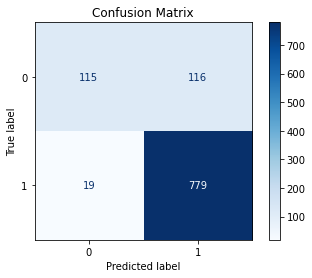

In [186]:
# Confusion Matrix
cm = confusion_matrix(y_test_sent, y_pred_sent)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

We have 98% recall for positive predicted labels but only a 50% for recall which is because there are many more positive labels compared to negative. This means our model is over predicting most of our tweets as positive as it's more likely to be correct due to a the imbalance of negative to positive tweets. We will want to artificially balance our tweets so there are more negative tweets for it to train off of

Sentiment Classification Accuracy: 0.8833819241982507
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.74      0.74       231
           1       0.93      0.92      0.92       798

    accuracy                           0.88      1029
   macro avg       0.83      0.83      0.83      1029
weighted avg       0.88      0.88      0.88      1029



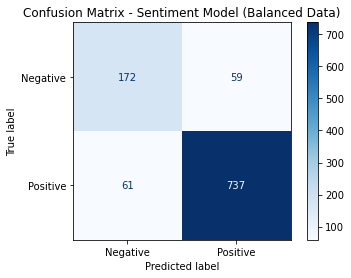

In [187]:
# Filter dataset to only include positive and negative sentiment
df_sentiment = df[df['vader_sentiment'] != 'Neutral emotion'].copy()

# Define target labels (1 for Positive, 0 for Negative)
y_sentiment = df_sentiment['vader_sentiment'].map({'Positive emotion': 1, 'Negative emotion': 0})

# Feature extraction: Convert text into numerical features (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X_sentiment = vectorizer.fit_transform(df_sentiment['clean_text'])  # Use raw text here

# Split into training and test sets BEFORE oversampling
X_train, X_test, y_train, y_test = train_test_split(X_sentiment, y_sentiment, test_size=0.2, random_state=42)

# Apply RandomOverSampler to balance the dataset
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_resampled, y_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate Model Performance
print("Sentiment Classification Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Sentiment Model (Balanced Data)")
plt.show()

Sentiment Classification Accuracy: 0.8688046647230321
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72       231
           1       0.92      0.91      0.91       798

    accuracy                           0.87      1029
   macro avg       0.81      0.82      0.82      1029
weighted avg       0.87      0.87      0.87      1029



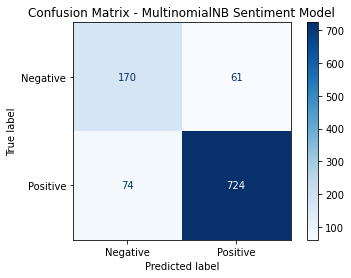

In [197]:
#Initialize model
model_MB = MultinomialNB()
# Train model using resampled data
model_MB.fit(X_resampled, y_resampled)

y_pred_mb = model_MB.predict(X_test)
# Evaluate Model Performance
mb_accuracy = accuracy_score(y_test, y_pred_mb)
mb_classification_report = classification_report(y_test, y_pred_mb, output_dict=True)

# Evaluate Model Performance
print("Sentiment Classification Accuracy:", accuracy_score(y_test, y_pred_mb))
print("Classification Report:\n", classification_report(y_test, y_pred_mb))
# Convert classification report to DataFrame for display
mb_classification_df = pd.DataFrame(mb_classification_report).transpose()

# Confusion Matrix
cm_mb = confusion_matrix(y_test, y_pred_mb)
disp_mb = ConfusionMatrixDisplay(confusion_matrix=cm_mb, display_labels=['Negative', 'Positive'])

# Plot confusion matrix
disp_mb.plot(cmap='Blues')
plt.title("Confusion Matrix - MultinomialNB Sentiment Model")
plt.show()

Sentiment Classification Accuracy: 0.8785228377065112

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.61      0.69       231
           1       0.90      0.95      0.92       798

    accuracy                           0.88      1029
   macro avg       0.85      0.78      0.81      1029
weighted avg       0.87      0.88      0.87      1029



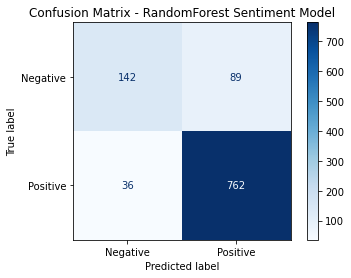

In [201]:
# Initialize model
model_RF = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

# Train model using resampled data
model_RF.fit(X_resampled, y_resampled)

# Make predictions
y_pred_rf = model_RF.predict(X_test)

# Evaluate Model Performance
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_classification_report = classification_report(y_test, y_pred_rf, output_dict=True)

# Print evaluation metrics
print("Sentiment Classification Accuracy:", rf_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Convert classification report to DataFrame for display
rf_classification_df = pd.DataFrame(rf_classification_report).transpose()

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Negative', 'Positive'])

# Plot confusion matrix
disp_rf.plot(cmap='Blues')
plt.title("Confusion Matrix - RandomForest Sentiment Model")
plt.show()


## Evaluation

My initial approach was to use keywords to create 

In [189]:
## 